# NLP Analysis of reviews
- Calculate sentiment and compare against the actual rating they user gave

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import os
import sys
sys.path.append(os.path.abspath("/Users/lucialarraona/Desktop/finalproject_socialgraphs22/Notebooks"))

from helper_functions import  *

import nltk 
from nltk.stem import PorterStemmer # para ver la raiz de las palabras(worker = work)
from nltk.tokenize import sent_tokenize, word_tokenize # para tokenizar las frases y las palabras 
import re # regex
import string

nltk.download('omw-1.4') #needed for lemmatizing

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer # an nltk package for sentiment analysis :D

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from statistics import mean

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lucialarraona/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lucialarraona/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [220]:
# With the reviews dataset, map the community for each user 
df_reviews = decompress_pickle('../Data/reviews_zipped.pbz2') 
print(df_reviews.shape)
df_reviews.head()

(1132367, 5)


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [221]:
df_recipes = decompress_pickle('../Data/file4.pbz2') 
df_ingredients = pd.read_csv('../Data/ingredients_with_recipies.csv')

In [222]:
df_recipes = df_recipes.rename(columns={'id':'recipe_id'})

In [223]:
df_recipes.head()

,name,recipe_id,minutes,ingredients,n_ingredients,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,"[winter squash, mexican seasoning, mixed spice...",7,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,"[prepared pizza crust, sausage patty, eggs, mi...",6,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,"[spreadable cheese with garlic and herbs, new ...",11,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,"[milk, vanilla ice cream, frozen apple juice c...",4,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,"[fennel seeds, green olives, ripe olives, garl...",9,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."


5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64


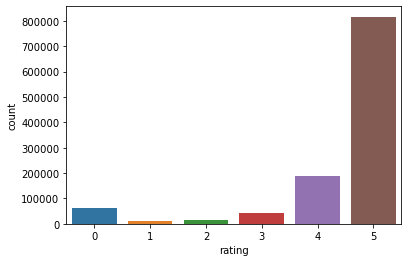

In [224]:
import seaborn as sns
sns.countplot(x='rating', data=df_reviews)
None
print(df_reviews['rating'].value_counts())

In [225]:
df_com_map = pd.read_csv('user_community_map.csv')
print(df_com_map.shape)
df_com_map.head()

(15257, 2)


,user_id,community
0,1535,3.0
1,3288,52.0
2,4439,16.0
3,4470,16.0
4,4769,35.0


In [226]:
df_reviews_raw = pd.merge(df_com_map, df_reviews, how="left", on=["user_id"]) # merging left is using only the keys on the left df, in this case df_com_map
print(df_reviews_raw.shape)
df_reviews_raw.head()

(144295, 6)


,user_id,community,recipe_id,date,rating,review
0,1535,3.0,349022,2010-02-11,4,"After being w/o power all day, it came back on..."
1,1535,3.0,50022,2004-09-09,5,This is an excellent recipe. Even my not-a-big...
2,1535,3.0,78834,2005-02-02,5,Made these for my kids one day as a surprise a...
3,1535,3.0,47474,2004-08-04,5,Love them!! A quick & easy recipe with ingredi...
4,1535,3.0,230720,2007-07-02,5,I was a little afraid this might not work very...


In [227]:
df_reviews_raw = pd.merge(df_reviews_raw, df_recipes, how='left',on =['recipe_id'])
df_reviews_raw = df_reviews_raw.dropna()
df_reviews_raw

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids
0,1535,3.0,349022,2010-02-11,4,"After being w/o power all day, it came back on...",slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,..."
1,1535,3.0,50022,2004-09-09,5,This is an excellent recipe. Even my not-a-big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ..."
3,1535,3.0,47474,2004-08-04,5,Love them!! A quick & easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,..."
4,1535,3.0,230720,2007-07-02,5,I was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]"
6,1535,3.0,87461,2004-10-26,5,This was incredible!! It is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]"
...,...,...,...,...,...,...,...,...,...,...,...
144290,2002371420,39.0,50245,2018-12-18,5,Made this with a slight variation. Added the p...,chicken francese,35.0,"[boneless skinless chicken breasts, condensed ...",11.0,"[1252, 1257, 7801, 4287, 2499, 5180, 2683, 320..."
144291,2002371445,5.0,2886,2018-12-19,5,I've been using this recipe for 2 years and it...,best banana bread,65.0,"[butter, granulated sugar, eggs, bananas, all-...",8.0,"[840, 3355, 2499, 342, 63, 335, 6270, 7449]"
144292,2002371627,52.0,153647,2018-12-19,0,Best thing about this recipe? I didn't have to...,tortilla crusted tilapia,30.0,"[tilapia fillets, corn tortillas, jalapeno pep...",9.0,"[7178, 7258, 3957, 4384, 2777, 1329, 3502, 637..."
144293,2002371843,61.0,516662,2018-12-19,5,This cake is incredible tasting and easy to ma...,black bean chocolate cake,65.0,"[black beans, eggs, pure vanilla extract, sea ...",9.0,"[553, 2499, 5767, 6352, 1609, 3723, 2485, 332,..."


In [228]:
# Make a copy to keep the raw dataframe for the future 
df_reviews2 = df_reviews_raw.reset_index(drop=True)

In [229]:
df_reviews2

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids
0,1535,3.0,349022,2010-02-11,4,"After being w/o power all day, it came back on...",slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,..."
1,1535,3.0,50022,2004-09-09,5,This is an excellent recipe. Even my not-a-big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ..."
2,1535,3.0,47474,2004-08-04,5,Love them!! A quick & easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,..."
3,1535,3.0,230720,2007-07-02,5,I was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]"
4,1535,3.0,87461,2004-10-26,5,This was incredible!! It is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]"
...,...,...,...,...,...,...,...,...,...,...,...
123663,2002371420,39.0,50245,2018-12-18,5,Made this with a slight variation. Added the p...,chicken francese,35.0,"[boneless skinless chicken breasts, condensed ...",11.0,"[1252, 1257, 7801, 4287, 2499, 5180, 2683, 320..."
123664,2002371445,5.0,2886,2018-12-19,5,I've been using this recipe for 2 years and it...,best banana bread,65.0,"[butter, granulated sugar, eggs, bananas, all-...",8.0,"[840, 3355, 2499, 342, 63, 335, 6270, 7449]"
123665,2002371627,52.0,153647,2018-12-19,0,Best thing about this recipe? I didn't have to...,tortilla crusted tilapia,30.0,"[tilapia fillets, corn tortillas, jalapeno pep...",9.0,"[7178, 7258, 3957, 4384, 2777, 1329, 3502, 637..."
123666,2002371843,61.0,516662,2018-12-19,5,This cake is incredible tasting and easy to ma...,black bean chocolate cake,65.0,"[black beans, eggs, pure vanilla extract, sea ...",9.0,"[553, 2499, 5767, 6352, 1609, 3723, 2485, 332,..."


In [230]:
df_reviews2.loc[123665]

user_id                                                  2002371627
community                                                      52.0
recipe_id                                                    153647
date                                                     2018-12-19
rating                                                            0
review            Best thing about this recipe? I didn't have to...
name                                       tortilla crusted tilapia
minutes                                                        30.0
ingredients       [tilapia fillets, corn tortillas, jalapeno pep...
n_ingredients                                                   9.0
ingredient_ids    [7178, 7258, 3957, 4384, 2777, 1329, 3502, 637...
Name: 123665, dtype: object

In [231]:
df_reviews2_filter = df_reviews2[df_reviews2['rating'] == 0]
df_reviews2_filter.loc[86]['review']

'FYI, these aren\'t "fat free" with chocolate chips in them. BUT, they do sound like an interesting lower fat alternative.'

In [232]:
df_reviews2_filter = df_reviews2[df_reviews2['rating'] == 1]
df_reviews2_filter.loc[123624]['review']

'What a huge mess!!!!!!! Try telling us what size of loaf this is supposed to be before having us try the recipe! I have a huge mess on my hands, a lot of cleanup, a lot of wasted ingredients and a major disappointment for my husband who was so looking forward to fresh bread. I read another review who said she made a 2 pound loaf, how is that possible?'

In [233]:
# Sentiment analyzer .vader() without cleaning the sentences. .Vader() is prepared for analyzins short sentences like tweets. So It's better 
# split the long reviews in sentences. 

""""
def scores2(text):
    compound = [sid.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(text)]
    pos = [sid.polarity_scores(sentence)["pos"] for sentence in nltk.sent_tokenize(text)]
    neg = [sid.polarity_scores(sentence)["neg"] for sentence in nltk.sent_tokenize(text)]
    neu = [sid.polarity_scores(sentence)["neu"] for sentence in nltk.sent_tokenize(text)]
    final_compound = np.mean(compound)
    final_pos = np.mean(pos)
    final_neg = np.mean(neg)
    final_neu = np.mean(neu)
    return final_compound, final_pos, final_neg, final_neu

print(df_reviews2['review'][0])
scores2(df_reviews2['review'][0])

#df_reviews2['compound']= df_reviews2['review'].apply(lambda x : scores2(x))
#df_reviews2
""" 

'"\ndef scores2(text):\n    compound = [sid.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(text)]\n    pos = [sid.polarity_scores(sentence)["pos"] for sentence in nltk.sent_tokenize(text)]\n    neg = [sid.polarity_scores(sentence)["neg"] for sentence in nltk.sent_tokenize(text)]\n    neu = [sid.polarity_scores(sentence)["neu"] for sentence in nltk.sent_tokenize(text)]\n    final_compound = np.mean(compound)\n    final_pos = np.mean(pos)\n    final_neg = np.mean(neg)\n    final_neu = np.mean(neu)\n    return final_compound, final_pos, final_neg, final_neu\n\nprint(df_reviews2[\'review\'][0])\nscores2(df_reviews2[\'review\'][0])\n\n#df_reviews2[\'compound\']= df_reviews2[\'review\'].apply(lambda x : scores2(x))\n#df_reviews2\n'

## Clean text from reviews

In [234]:
def text_cleaning(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

stopwords = nltk.corpus.stopwords.words('english')

ps = PorterStemmer()
wn = nltk.WordNetLemmatizer()

def clean_stem (review):

    temp1 ="".join(x for x in review if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3


def clean_lemma (review):
    
    temp1 ="".join(x for x in review if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [wn.lemmatize(x) for x in temp2 if x not in stopwords]
    return temp3


df_reviews2['review'] =df_reviews2['review'] .astype('str')  # object to string
df_reviews2['review'] = df_reviews2['review'] .apply(text_cleaning) # cleaning 
df_reviews2['review_tokens']= df_reviews2['review'].map(clean_lemma) # apply lemmatization for now

In [235]:
df_reviews2.head()

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,review_tokens
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...","[w, power, day, came, back, right, bedtime, qu..."
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...","[excellent, recipe, even, big, fan, banana, br..."
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...","[love, quick, easy, recipe, ingredient, always..."
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]","[little, afraid, might, work, well, turned, lo..."
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]","[incredible, best, garlic, bread, ever, made, ..."


In [236]:
#//// Sanity check of differneces between lemmatizing and stemming
print(df_reviews2['review'][0])
print(clean_lemma(df_reviews2['review'][0]))
print()
print(df_reviews2['review'][0])
print(clean_stem(df_reviews2['review'][0]))

after being w o power all day  it came back on right before bedtime  i quickly threw all the fresh vegetables  raw chicken  broth and bouillon into the crock pot  so i could cook it overnight for the next day s lunch  the next morning  i added the tomatoes and beans and turned the crock pot down to  warm   everything cooked up nice and tender  i really don t think you need to precook the chicken  it literally fell apart it was so tender  i skipped the butter and tabasco sauce since i didn t need the fat  and i don t care for too much heat 
['w', 'power', 'day', 'came', 'back', 'right', 'bedtime', 'quickly', 'threw', 'fresh', 'vegetable', 'raw', 'chicken', 'broth', 'bouillon', 'crock', 'pot', 'could', 'cook', 'overnight', 'next', 'day', 'lunch', 'next', 'morning', 'added', 'tomato', 'bean', 'turned', 'crock', 'pot', 'warm', 'everything', 'cooked', 'nice', 'tender', 'really', 'think', 'need', 'precook', 'chicken', 'literally', 'fell', 'apart', 'tender', 'skipped', 'butter', 'tabasco', 's

In [237]:
sid = SentimentIntensityAnalyzer()


# Sentiment compound value of reviews
def sentiment(x):
    score = sid.polarity_scores(x)
    return score['compound']


#  Add Positive y Negative tag 
def cls(x):
    list1=[]
    for i in x["score"]:
        if i>0:
            list1.append("Positive")
        elif i==0:
            list1.append("Neutral")
        else:
            list1.append("Negative")
    x["sentiment"]=list1



df_reviews2['score']= df_reviews2['review'].apply(lambda x : sentiment(x)) #score
cls(df_reviews2) # tag (for plotting)
df_reviews2.head() 


,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,review_tokens,score,sentiment
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...","[w, power, day, came, back, right, bedtime, qu...",0.8481,Positive
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...","[excellent, recipe, even, big, fan, banana, br...",0.9707,Positive
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...","[love, quick, easy, recipe, ingredient, always...",0.6486,Positive
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]","[little, afraid, might, work, well, turned, lo...",0.9722,Positive
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]","[incredible, best, garlic, bread, ever, made, ...",0.8860,Positive


In [238]:
import plotly as ply
import plotly.graph_objs as go

Mno=df_reviews2[df_reviews2.sentiment=="Positive"]["score"].count()
Fno=df_reviews2[df_reviews2.sentiment=="Negative"]["score"].count()
Nno=df_reviews2[df_reviews2.sentiment=="Neutral"]["score"].count()
labels = ["Positive Comments","Negative Comments","Neutral Comments"]
values = [Mno,Fno,Nno]
fig = go.Figure(data=[go.Pie(labels=labels, values=values,hole=0.4)])
fig.show()

In [239]:
# Rescaling the score to 0-1 and then divinding by 5 to match the range of the rating and comapre

from sklearn.preprocessing import minmax_scale

df_reviews2[['score_scale']] = minmax_scale(df_reviews2[['score']])
df_reviews2[['score_scale2']] = df_reviews2[['score_scale']]*5
df_reviews2

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,review_tokens,score,sentiment,score_scale,score_scale2
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...","[w, power, day, came, back, right, bedtime, qu...",0.8481,Positive,0.923671,4.618357
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...","[excellent, recipe, even, big, fan, banana, br...",0.9707,Positive,0.985603,4.928016
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...","[love, quick, easy, recipe, ingredient, always...",0.6486,Positive,0.822894,4.114468
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]","[little, afraid, might, work, well, turned, lo...",0.9722,Positive,0.986361,4.931804
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]","[incredible, best, garlic, bread, ever, made, ...",0.8860,Positive,0.942817,4.714084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123663,2002371420,39.0,50245,2018-12-18,5,made this with a slight variation added the p...,chicken francese,35.0,"[boneless skinless chicken breasts, condensed ...",11.0,"[1252, 1257, 7801, 4287, 2499, 5180, 2683, 320...","[made, slight, variation, added, parmesan, che...",0.0000,Neutral,0.495252,2.476258
123664,2002371445,5.0,2886,2018-12-19,5,i ve been using this recipe for years and its...,best banana bread,65.0,"[butter, granulated sugar, eggs, bananas, all-...",8.0,"[840, 3355, 2499, 342, 63, 335, 6270, 7449]","[using, recipe, year, one, use, tried, several...",0.1779,Positive,0.585118,2.925591
123665,2002371627,52.0,153647,2018-12-19,0,best thing about this recipe i didn t have to...,tortilla crusted tilapia,30.0,"[tilapia fillets, corn tortillas, jalapeno pep...",9.0,"[7178, 7258, 3957, 4384, 2777, 1329, 3502, 637...","[best, thing, recipe, scroll, past, rambling, ...",0.9572,Positive,0.978784,4.893918
123666,2002371843,61.0,516662,2018-12-19,5,this cake is incredible tasting and easy to ma...,black bean chocolate cake,65.0,"[black beans, eggs, pure vanilla extract, sea ...",9.0,"[553, 2499, 5767, 6352, 1609, 3723, 2485, 332,...","[cake, incredible, tasting, easy, make, froste...",0.8519,Positive,0.925591,4.627955


In [240]:
df_reviews2.loc[123665]

user_id                                                  2002371627
community                                                      52.0
recipe_id                                                    153647
date                                                     2018-12-19
rating                                                            0
review            best thing about this recipe  i didn t have to...
name                                       tortilla crusted tilapia
minutes                                                        30.0
ingredients       [tilapia fillets, corn tortillas, jalapeno pep...
n_ingredients                                                   9.0
ingredient_ids    [7178, 7258, 3957, 4384, 2777, 1329, 3502, 637...
review_tokens     [best, thing, recipe, scroll, past, rambling, ...
score                                                        0.9572
sentiment                                                  Positive
score_scale                                     

In [241]:
# Mean, 10th and 90th percentile of the sentiment

mean_rev= df_reviews2['rating'].describe()['mean']

print(f'The mean of the sentiment in the reviews: {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(df_reviews2['rating'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(df_reviews2['rating'], 10))


# Add the percentiles to a list for the plotting
percentiles = [np.percentile(df_reviews2['rating'], 90), np.percentile(df_reviews2['rating'], 10)]

The mean of the sentiment in the reviews: 4.464267231620144
90th percentile of the sentiment:  5.0
10th percentile of the sentiment:  4.0


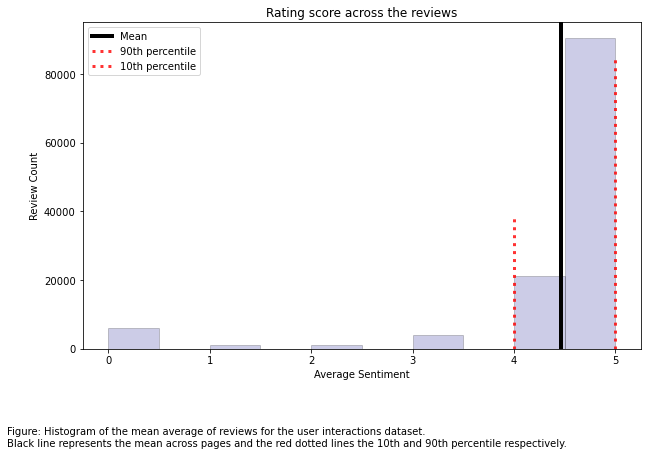

In [242]:
list_sentiment = list(zip(df_reviews2['user_id'], df_reviews2['rating']))

def plot_pretty_hist(list_data, percentiles, mean, plot_perct = False, title = str, color=str):

    x = [val for (node, val) in list_data]
    fig,ax = plt.subplots(figsize = (10,6))
    cnts, values, bars = ax.hist(x, edgecolor='black', 
                                        bins=10,
                                        color=color,
                                        alpha = 0.2)

    if plot_perct == True:
        # Plot mean
        ax.axvline(mean, color='black', linestyle = '-', linewidth=4) 
        # Plot percentiles and mean lines
        quants = [[percentiles[0], 0.8, 0.90], [percentiles[1], 0.8, 0.40]]
        for i in quants:
            ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'Red' ,linewidth=3)  

        
        # Labels and titles
        ax.set_ylabel("Review Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean','90th percentile','10th percentile'])
        caption = ("Figure: Histogram of the mean average of reviews for the user interactions dataset.\n"
                    "Black line represents the mean across pages and the red dotted lines the 10th and 90th percentile respectively.")
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()
        
        

    else:
        
        # Plot the mean
        ax.axvline(mean, color='black', linewidth=4) 
        
        # Labels and titles
        ax.set_ylabel("Page Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean'])
        caption = ('haha')
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()

    return None

plot_pretty_hist(list_sentiment,percentiles, mean_rev, plot_perct= True, 
                 title="Rating score across the reviews",
                 color = 'darkblue')

In [243]:
# Mean, 10th and 90th percentile of the sentiment

mean_rev= df_reviews2['score_scale2'].describe()['mean']

print(f'The mean of the sentiment in the reviews: {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(df_reviews2['score_scale2'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(df_reviews2['score_scale2'], 10))


# Add the percentiles to a list for the plotting
percentiles = [np.percentile(df_reviews2['score_scale2'], 90), np.percentile(df_reviews2['score_scale2'], 10)]

The mean of the sentiment in the reviews: 4.447517539791296
90th percentile of the sentiment:  4.938876540715297
10th percentile of the sentiment:  3.588603758335018


In [244]:
list_sentiment = list(zip(df_reviews2['user_id'], df_reviews2['score_scale2']))

In [245]:
def plot_pretty_hist(list_data, percentiles, mean, plot_perct = False, title = str, color=str):

    x = [val for (node, val) in list_data]
    fig,ax = plt.subplots(figsize = (10,6))
    cnts, values, bars = ax.hist(x, edgecolor='black', 
                                        bins=10,
                                        color=color,
                                        alpha = 0.2)

    if plot_perct == True:
        # Plot mean
        ax.axvline(mean, color='black', linestyle = '-', linewidth=4) 
        # Plot percentiles and mean lines
        quants = [[percentiles[0], 0.8, 0.90], [percentiles[1], 0.8, 0.40]]
        for i in quants:
            ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'Red' ,linewidth=3)  

        
        # Labels and titles
        ax.set_ylabel("Review Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean','90th percentile','10th percentile'])
        caption = ("Figure: Histogram of the mean average of reviews for the user interactions dataset.\n"
                    "Black line represents the mean across pages and the red dotted lines the 10th and 90th percentile respectively.")
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()
        
        

    else:
        
        # Plot the mean
        ax.axvline(mean, color='black', linewidth=4) 
        
        # Labels and titles
        ax.set_ylabel("Page Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean'])
        caption = ('haha')
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()

    return None

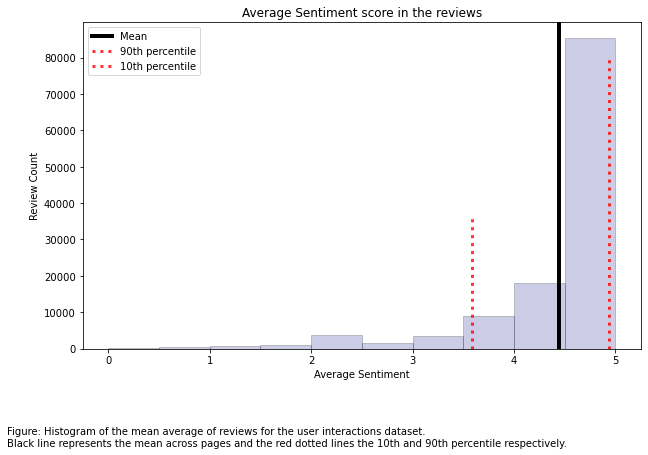

In [246]:
plot_pretty_hist(list_sentiment,percentiles, mean_rev, plot_perct= True, 
                 title="Average Sentiment score in the reviews",
                 color = 'darkblue')

> **Label permutation test to investigate the two hypotheses below**
>* **H1: Good reviews (>4 rating) have a higher averge value for sentiment than a similarly sized set of randomly rated reviews.**
>* **H2: Bad reviews (<4) have a lower average value for sentiment than a similarly sized set of randomly rated reviews.**
>* **Write a short paragraph reflecting on your findings.**

In [247]:
# We will relabel de dataset for easier permutation test analysis:
threshold = 3.5
df_reviews2['good'] = df_reviews2['score_scale2'].map(lambda x: 1 if x > threshold else 0)
df_reviews2['bad'] = df_reviews2['score_scale2'].map(lambda x: 1 if x < threshold else 0 )
df_reviews2.head()

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,review_tokens,score,sentiment,score_scale,score_scale2,good,bad
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,"[5010, 1130, 1093, 3184, 6270, 590, 1708, 840,...","[w, power, day, came, back, right, bedtime, qu...",0.8481,Positive,0.923671,4.618357,1,0
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,"[840, 6906, 342, 2499, 7449, 335, 2683, 6270, ...","[excellent, recipe, even, big, fan, banana, br...",0.9707,Positive,0.985603,4.928016,1,0
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,"[5695, 6906, 6473, 2499, 7449, 6270, 911, 332,...","[love, quick, easy, recipe, ingredient, always...",0.6486,Positive,0.822894,4.114468,1,0
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,"[673, 525, 3234, 1645, 4249, 1792]","[little, afraid, might, work, well, turned, lo...",0.9722,Positive,0.986361,4.931804,1,0
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,"[2718, 4574, 4623, 3219, 5180]","[incredible, best, garlic, bread, ever, made, ...",0.8860,Positive,0.942817,4.714084,1,0


In [248]:
# Shuffle the good/bad attribute

avg_score_shuffle_good = []
avg_score_shuffle_bad = []
avg_score_good = []
avg_score_bad = []


for _ in range(1000):
    
    # Create a list of shuffled good attribute and append it to the df_reviews2
    df_reviews2['good_shuffled'] = np.random.permutation(df_reviews2['good'])
    df_reviews2['bad_shuffled'] = np.random.permutation(df_reviews2['bad'])
    
    # Create a new df for every iteration on the loop 
    df_test = pd.DataFrame() 
    df_test['user_id'] = df_reviews2['user_id']       #character
    df_test['good_true'] = df_reviews2['good']              #true labels
    df_test['bad_true'] = df_reviews2['bad'] # true labels
    df_test['good_shuffled'] = df_reviews2['good_shuffled'] #shuffled labels
    df_test['bad_shuffled'] = df_reviews2['bad_shuffled']  #shuffled labels
    df_test['score_scale2'] = df_reviews2['score_scale2']


    # group with just characters and shuffled labels (random group)
    shuffled_group_good = df_test[df_test['good_shuffled']== 1] # good characters
    avg_score_shuffle_good.append(np.mean(shuffled_group_good['score_scale2'])) 
    
    # group with just characters and shuffled labels (random group)
    shuffled_group_bad = df_test[df_test['bad_shuffled']== 1] # bad characters
    avg_score_shuffle_bad.append(np.mean(shuffled_group_bad['score_scale2']))

# group with just characters and their true labels 
true_group_good = df_reviews2[df_reviews2['good'] == 1]
avg_score_good = np.mean(true_group_good['score_scale2']) #it will always be the same number because of the true labels

# group with just characters and their true labels 
true_group_bad = df_reviews2[df_reviews2['bad'] == 1]
avg_score_bad = np.mean(true_group_bad['score_scale2']) #it will always be the same number because of the true labels

In [249]:
def plot_pretty_hist_pair(shuffled_group_good, true_group_good, shuffled_group_bad, true_group_bad):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))


    # H1
    list_shuffle_good = list(zip(shuffled_group_good['user_id'], shuffled_group_good['score_scale2']))
    x_good = [val for (node, val) in list_shuffle_good]
    
    cnts, values, bars = ax1.hist(x_good, edgecolor='black', 
                                     bins=20,
                                     color='green',
                                     alpha = 0.2)

    # Mean of shuffled labels
    ax1.axvline(mean(avg_score_shuffle_good), color='green', linewidth=2)
    # Mean of true labels
    ax1.axvline(avg_score_good, color='black', linewidth=2)

    # Labels and titles
    ax1.set_ylabel("Page Count")
    ax1.set_xlabel("Average Sentiment")
    ax1.set_title("Sentiment score in Good Reviews: True vs shuffled labels")
    ax1.legend(['Mean Shuffled Good Reviews','Mean True Good Reviews'])


    
    
    # ----------------------------
    
    # H2
    list_shuffle = list(zip(shuffled_group_bad['user_id'], shuffled_group_bad['score_scale2']))
    x = [val for (node, val) in list_shuffle]
    cnts, values, bars = ax2.hist(x, edgecolor='black', 
                                     bins=20,
                                     color='red',
                                     alpha = 0.2)
    # Mean of shuffled labels
    ax2.axvline(mean(avg_score_shuffle_bad), color='red', linewidth=2) 
    # Mean of true labels
    ax2.axvline(avg_score_bad, color='black', linewidth=2) 
    

    # Labels and titles
    ax2.set_ylabel("Page Count")
    ax2.set_xlabel("Average Sentiment")
    ax2.set_title("Sentiment score in Bad Reviews: True vs shuffled labels")
    ax2.legend(['Mean Shuffled Bad Reviews','Mean True Bad Reviews'])


    plt.show()

    pass

    return None

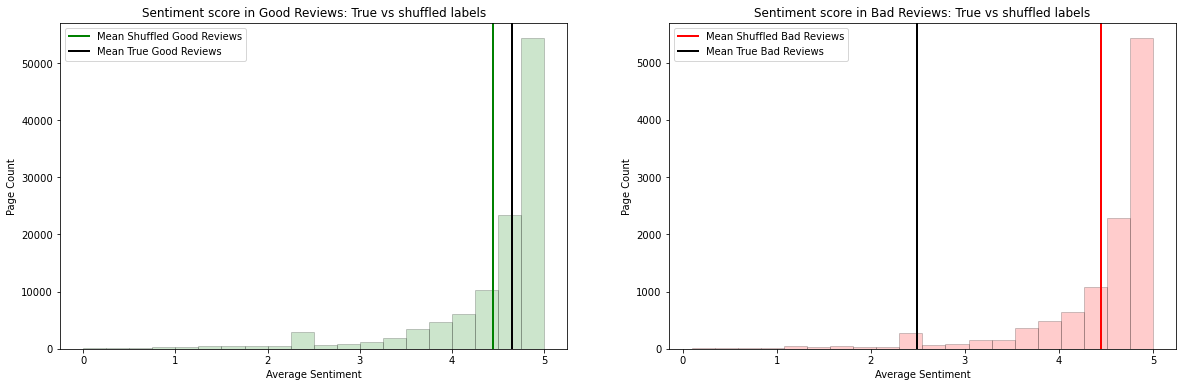

In [250]:
plot_pretty_hist_pair(shuffled_group_good, true_group_good, shuffled_group_bad, true_group_bad)

> In conclusion, the average sentiment for the good reviews is lower than a random group of reviews with shuffled labels, determining which is expected as the number of good reviews and good words is higher in our dataset

> The true average sentiment for the bad reviews is way lower than a random group of shuffled labels, also because of lower representation of the bad reviews. 

Both hypothesis are correct for the (unbalanced) good and bad reviews groups.

In [251]:
df_reviews2['true_labels'] = df_reviews2['score_scale2'].map(lambda x: 1 if x > threshold else 0)
df_reviews2['true_labels'].value_counts()

1    112354
0     11314
Name: true_labels, dtype: int64

In [252]:
df_slice1= df_reviews2[df_reviews2['true_labels'] == 1].head(11314)
df_slice2 = df_reviews2[df_reviews2['true_labels'] == 0]
new_df = pd.concat([df_slice1,df_slice2])
print(new_df['true_labels'].value_counts())
new_df.head()

1    11314
0    11314
Name: true_labels, dtype: int64


,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,...,review_tokens,score,sentiment,score_scale,score_scale2,good,bad,good_shuffled,bad_shuffled,true_labels
0,1535,3.0,349022,2010-02-11,4,after being w o power all day it came back on...,slow cooker chicken tomato and white bean soup,495.0,"[onion, celery ribs, carrots, garlic, salt, bl...",14.0,...,"[w, power, day, came, back, right, bedtime, qu...",0.8481,Positive,0.923671,4.618357,1,0,1,0,1
1,1535,3.0,50022,2004-09-09,5,this is an excellent recipe even my not a big...,the best banana bread,85.0,"[butter, sugar, bananas, eggs, vanilla, baking...",10.0,...,"[excellent, recipe, even, big, fan, banana, br...",0.9707,Positive,0.985603,4.928016,1,0,1,0,1
2,1535,3.0,47474,2004-08-04,5,love them a quick easy recipe with ingredi...,lemon cooler cookies,33.0,"[powdered sugar, sugar, shortening, egg, vanil...",10.0,...,"[love, quick, easy, recipe, ingredient, always...",0.6486,Positive,0.822894,4.114468,1,0,1,0,1
3,1535,3.0,230720,2007-07-02,5,i was a little afraid this might not work very...,red white and blue jello flag,260.0,"[boiling water, berry blue gelatin mix, gelati...",6.0,...,"[little, afraid, might, work, well, turned, lo...",0.9722,Positive,0.986361,4.931804,1,0,1,0,1
4,1535,3.0,87461,2004-10-26,5,this was incredible it is the best garlic br...,my own garlic bread,30.0,"[french bread, margarine, mayonnaise, garlic s...",5.0,...,"[incredible, best, garlic, bread, ever, made, ...",0.8860,Positive,0.942817,4.714084,1,0,0,0,1


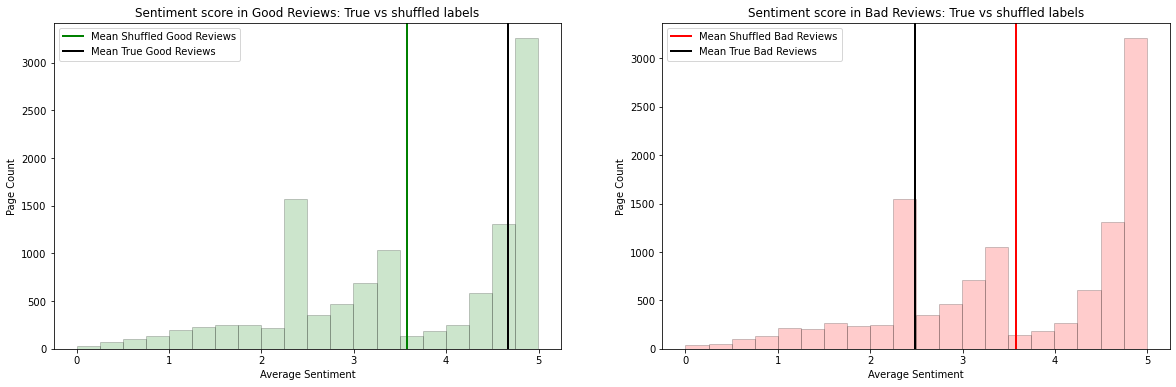

In [253]:
# Shuffle the good/bad attribute

avg_score_shuffle_good = []
avg_score_shuffle_bad = []
avg_score_good = []
avg_score_bad = []


for _ in range(1000):
    
    # Create a list of shuffled good attribute and append it to the new_df
    new_df['good_shuffled'] = np.random.permutation(new_df['good'])
    new_df['bad_shuffled'] = np.random.permutation(new_df['bad'])
    
    # Create a new df for every iteration on the loop 
    df_test = pd.DataFrame() 
    df_test['user_id'] = new_df['user_id']       #character
    df_test['good_true'] = new_df['good']              #true labels
    df_test['bad_true'] = new_df['bad'] # true labels
    df_test['good_shuffled'] = new_df['good_shuffled'] #shuffled labels
    df_test['bad_shuffled'] = new_df['bad_shuffled']  #shuffled labels
    df_test['score_scale2'] = new_df['score_scale2']


    # group with just characters and shuffled labels (random group)
    shuffled_group_good = df_test[df_test['good_shuffled']== 1] # good characters
    avg_score_shuffle_good.append(np.mean(shuffled_group_good['score_scale2'])) 
    
    # group with just characters and shuffled labels (random group)
    shuffled_group_bad = df_test[df_test['bad_shuffled']== 1] # bad characters
    avg_score_shuffle_bad.append(np.mean(shuffled_group_bad['score_scale2']))

# group with just characters and their true labels 
true_group_good = new_df[new_df['good'] == 1]
avg_score_good = np.mean(true_group_good['score_scale2']) #it will always be the same number because of the true labels

# group with just characters and their true labels 
true_group_bad = new_df[new_df['bad'] == 1]
avg_score_bad = np.mean(true_group_bad['score_scale2']) #it will always be the same number because of the true labels


plot_pretty_hist_pair(shuffled_group_good, true_group_good, shuffled_group_bad, true_group_bad)

# Visualization of wordcloud for positive and negative reviews
- Wordclouds of the positive and negative words found in the already grouped positive and negative reviews

In [254]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (10,10))
    wc = WordCloud(background_color = bgcolor, max_words = 50,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

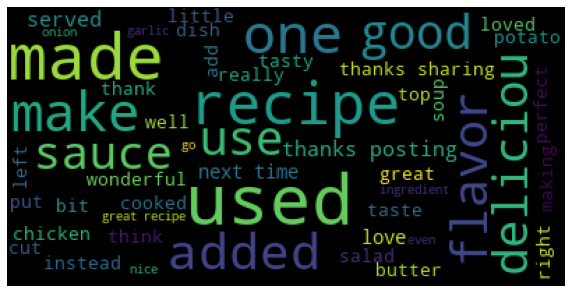

In [255]:
# Good reviews - Most common words (TF)

df_good = new_df[new_df['rating'] == 5]
list_words  = list(df_good["review_tokens"])
flat_list = [item for sublist in list_words for item in sublist]
wc(flat_list,'black','Common Words' )

Words in good reviews
[('', 11114), ('recipe', 9648), ('used', 5739), ('made', 5374), ('thanks', 5183), ('make', 3857), ('flavor', 2714), ('great', 2690), ('time', 2600), ('added', 2556)]


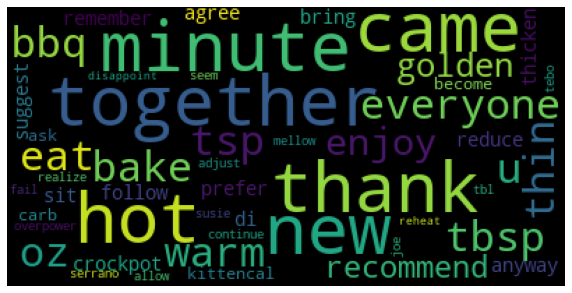

In [256]:
# Calculate TFIDF for the ingredient list of good reviews (flat_list)

from nltk.probability import FreqDist
TF_com = FreqDist(flat_list)

most_common = TF_com.most_common(10)
print(f'Words in good reviews')
print(most_common)

import math
IDF = []
for term, term_freq in TF_com.items():
    term_IDF = math.log(float(1) / term_freq + 1)
    IDF.append((term,term_IDF))

# convert to dict to multiply easy
dict_1 = dict(TF_com)
dict_2 = dict(IDF)
TF_IDF = {key: dict_1[key] * dict_2[key] for key in dict_1}
TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=True))
#print(TF_IDF)
wc(TF_IDF.keys(),'black','Common Words' )

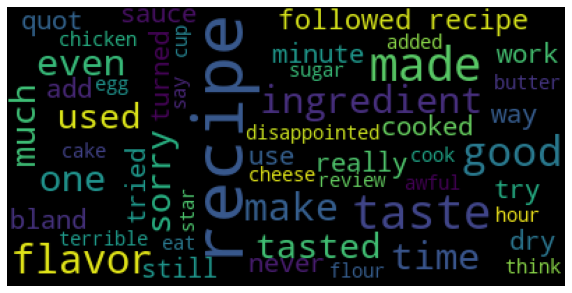

In [257]:
df_bad= new_df[new_df['rating'] == 1]
list_words  = list(df_bad["review_tokens"])
flat_list = [item for sublist in list_words for item in sublist]
wc(flat_list,'black','Common Words' )

Words in bad reviews
[('', 590), ('recipe', 420), ('like', 164), ('made', 120), ('taste', 119), ('time', 117), ('followed', 110), ('would', 106), ('make', 98), ('good', 90)]


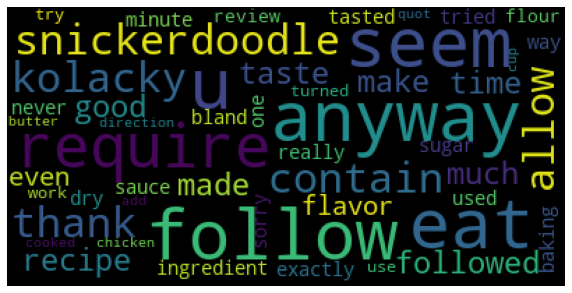

In [258]:
# Calculate TFIDF for the ingredient list of good reviews (flat_list)

from nltk.probability import FreqDist
TF_com = FreqDist(flat_list)

most_common = TF_com.most_common(10)
print(f'Words in bad reviews')
print(most_common)

import math
IDF = []
for term, term_freq in TF_com.items():
    term_IDF = math.log(float(1) / term_freq + 1)
    IDF.append((term,term_IDF))

# convert to dict to multiply easy
dict_1 = dict(TF_com)
dict_2 = dict(IDF)
TF_IDF = {key: dict_1[key] * dict_2[key] for key in dict_1}
TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=True))
#print(TF_IDF)
wc(TF_IDF.keys(),'black','Common Words' )

# Highest rated ingredients and worst rated ingredients
- 10 most popular ingredients from highest rated reviews
- 10 least popular ingredients from lowest rated reviews

In [259]:
# Take 10 most popular recipes (sort daframe by rating)

#top_rated = df_reviews2.sort_values(by=['rating'], ascending=False).head(10)
top_rated = df_reviews2[df_reviews2['rating'] == 5]
list_ing  = list(top_rated["ingredients"])
flat_list_ing = [item for sublist in list_ing for item in sublist]
freq_ing_top_rated = nltk.FreqDist(flat_list_ing).most_common(10)
freq_ing_top_rated

[('salt', 38268),
 ('butter', 24508),
 ('sugar', 17416),
 ('onion', 15379),
 ('olive oil', 14640),
 ('eggs', 13217),
 ('water', 12812),
 ('flour', 11430),
 ('garlic cloves', 11074),
 ('milk', 10477)]

In [260]:
TF_com = FreqDist(flat_list_ing)

most_common = TF_com.most_common(10)
print(f'Most popular ingredients (among best rated reviews)')
print(most_common)

import math
IDF = []
for term, term_freq in TF_com.items():
    term_IDF = math.log(float(1) / term_freq + 1)
    IDF.append((term,term_IDF))

# convert to dict to multiply easy
dict_1 = dict(TF_com)
dict_2 = dict(IDF)
TF_IDF = {key: dict_1[key] * dict_2[key] for key in dict_1}
TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=False)) # reverse to check the lowest TFIDF scores
print('Most popoular ingredients TFIDF filtered (lower TFIDF score)')
list(TF_IDF.items())[:10]

Most popular ingredients (among best rated reviews)
[('salt', 38268), ('butter', 24508), ('sugar', 17416), ('onion', 15379), ('olive oil', 14640), ('eggs', 13217), ('water', 12812), ('flour', 11430), ('garlic cloves', 11074), ('milk', 10477)]
Most popoular ingredients TFIDF filtered (lower TFIDF score)


[('white chocolate baking bar', 0.6931471805599453),
 ('9 inch cake layers', 0.6931471805599453),
 ('red gelatin', 0.6931471805599453),
 ('butter mints', 0.6931471805599453),
 ('tomato soup mix', 0.6931471805599453),
 ('custard', 0.6931471805599453),
 ('sponge cake fingers', 0.6931471805599453),
 ('diced tomatoes with balsamic vinegar basil and oil', 0.6931471805599453),
 ('low-fat granola cereal', 0.6931471805599453),
 ('ground cranberries', 0.6931471805599453)]

In [261]:
worst_rated = df_reviews2[df_reviews2['rating'] == 0]
list_ing  = list(worst_rated["ingredients"])
flat_list_ing = [item for sublist in list_ing for item in sublist]
freq_ing_worst_rated = nltk.FreqDist(flat_list_ing).most_common(10)
freq_ing_worst_rated

[('salt', 3035),
 ('butter', 1907),
 ('sugar', 1451),
 ('eggs', 1251),
 ('flour', 1172),
 ('onion', 1142),
 ('water', 1089),
 ('milk', 924),
 ('baking powder', 811),
 ('olive oil', 751)]

In [262]:
TF_com = FreqDist(flat_list_ing)

most_common = TF_com.most_common(10)
print(f'Least popular ingredients (among best rated reviews)')
print(most_common)

import math
IDF = []
for term, term_freq in TF_com.items():
    term_IDF = math.log(float(1) / term_freq + 1)
    IDF.append((term,term_IDF))

# convert to dict to multiply easy
dict_1 = dict(TF_com)
dict_2 = dict(IDF)
TF_IDF = {key: dict_1[key] * dict_2[key] for key in dict_1}
TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=False))
print('Least popoular ingredients TFIDF filtered (lower TFIDF score)')
list(TF_IDF.items())[:10]

Least popular ingredients (among best rated reviews)
[('salt', 3035), ('butter', 1907), ('sugar', 1451), ('eggs', 1251), ('flour', 1172), ('onion', 1142), ('water', 1089), ('milk', 924), ('baking powder', 811), ('olive oil', 751)]
Least popoular ingredients TFIDF filtered (lower TFIDF score)


[('raw sugar', 0.6931471805599453),
 ('salted peanuts', 0.6931471805599453),
 ('lemon flavor instant pudding and pie filling', 0.6931471805599453),
 ('simply potatoes traditional mashed potatoes', 0.6931471805599453),
 ('white cheddar cheese', 0.6931471805599453),
 ('cheese whiz', 0.6931471805599453),
 ('sweet red pepper', 0.6931471805599453),
 ('reduced-calorie hot dog buns', 0.6931471805599453),
 ('reduced-fat american cheese', 0.6931471805599453),
 ('boneless sirloin', 0.6931471805599453)]

# Community analysis of Actual Rating vs Calculated Score
* a) Rating vs Sentiment score by community
* b) Rating vs Sentiment score by recipe in each community
    - How many recipes in each community have the same score?
* c) Rating vs Sentiment score by user in each community
    - How many recipes have each user rated?

### a) **Average Rating vs Sentiment score by community**

In [263]:
df_mean_rating= pd.DataFrame(df_reviews2.groupby(by=["community"])['rating','score_scale2'].mean())
df_mean_rating

,rating,score_scale2
community,,
0.0,3.977941,4.196670
1.0,4.194121,4.368986
2.0,4.300000,4.263244
3.0,4.166857,4.360530
4.0,4.528682,3.844974
...,...,...
66.0,4.500000,3.847621
67.0,4.400000,4.024382
68.0,2.142857,3.227961


In [264]:
df_mean_rating = df_mean_rating.reset_index()

In [265]:
largest_com = [16.0, 5.0, 3.0, 40.0, 1.0, 26.0, 4.0, 48.0, 2.0, 32.0]
df_mean_rating[df_mean_rating['community'].isin(largest_com)]

,community,rating,score_scale2
1,1.0,4.194121,4.368986
2,2.0,4.300000,4.263244
3,3.0,4.166857,4.360530
4,4.0,4.528682,3.844974
5,5.0,4.183773,4.338912
16,16.0,4.693459,4.613557
26,26.0,4.430921,4.337161
32,32.0,4.306252,4.414411
40,40.0,4.260398,4.403430
48,48.0,3.561480,4.082009


In [266]:
fig = px.bar(
    data_frame = df_mean_rating,
    x = "community",
    y = ["rating","score_scale2"],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
    color_discrete_map={'rating':'green', 'score_scale2':'orange'},
    title='Average Rating vs Average Calculated Sentiment Score (per community)',
)

fig.update_layout(

  xaxis_title= 'Community',
yaxis_title = 'Score vs Rating',

)


### b) **Average Rating vs Sentiment score per recipe by community**

In [289]:
df_mean_rating_recipe= pd.DataFrame(df_reviews2.groupby(by=["community",'recipe_id'])['rating','score_scale2'].mean())
df_mean_rating_recipe

rating  score_scale2
community recipe_id                      
0.0       3343         5.00      4.693372
          7913         5.00      4.566074
          8108         5.00      3.635078
          11523        5.00      1.728632
          12619        5.00      3.286017
...                     ...           ...
70.0      76043        3.00      4.763336
          138708       2.00      3.845979
          175091       3.75      3.380670
          293133       5.00      4.897707
          412064       5.00      4.712063

[90435 rows x 2 columns]

In [296]:
# Mean, 10th and 90th percentile of the sentiment in each community

# Select community 0
com0 = df_mean_rating_recipe['rating'].loc[48, :]
com0 = com0.reset_index()

mean_rev= com0['rating'].describe()['mean']

print(f'The mean of the sentiment in the reviews in community : {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(com0['rating'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(com0['rating'], 10))


# Add the percentiles to a list for the plotting
percentiles = [np.percentile(com0['rating'], 90), np.percentile(com0['rating'], 10)]

The mean of the sentiment in the reviews in community : 3.9755751076601378
90th percentile of the sentiment:  5.0
10th percentile of the sentiment:  1.7282051282051283


In [268]:
df_mean_rating_recipe = df_mean_rating_recipe.reset_index()
largest_com = [16.0, 5.0, 3.0, 40.0, 1.0, 26.0, 4.0, 48.0, 2.0, 32.0]
df_mean_rating_recipe[df_mean_rating_recipe['community'].isin(largest_com)]

,community,recipe_id,rating,score_scale2
129,1.0,456,5.0,4.623156
130,1.0,519,5.0,4.914629
131,1.0,749,5.0,4.442059
132,1.0,1151,5.0,4.920691
133,1.0,2072,5.0,4.390533
...,...,...,...,...
85613,48.0,535650,5.0,4.506719
85614,48.0,535652,5.0,3.990200
85615,48.0,535653,5.0,3.881340
85616,48.0,535783,4.0,4.360982


In [269]:
# Select community 0
com0 = df_mean_rating_recipe.loc[1, :]

com0
com0 = com0.reset_index()
com0['recipe_id'] = com0['recipe_id'].astype(str)
com0_bestrated = com0[com0['score_scale2'] == com0['score_scale2'].max()]
com0_bestrated

KeyError: 'recipe_id'

In [ ]:
filter_best_recipe = df_reviews2[df_reviews2['recipe_id'] == 115731]
filter_best_recipe

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,...,review_tokens,score,sentiment,score_scale,score_scale2,good,bad,good_shuffled,bad_shuffled,true_labels
82017,486725,16.0,115731,2009-10-20,5,wow what an awesome side dish i skipped the ...,roasted cauliflower with sun dried tomatoes ...,60.0,"[cauliflower, olive oil, garlic cloves, lemon,...",9.0,...,"[wow, awesome, side, dish, skipped, cup, oil, ...",0.9589,Positive,0.979642,4.898212,1,0,1,0,1
95204,1058984,1.0,115731,2013-09-16,5,let me start off by saying i am not a fan of c...,roasted cauliflower with sun dried tomatoes ...,60.0,"[cauliflower, olive oil, garlic cloves, lemon,...",9.0,...,"[let, start, saying, fan, caper, really, like,...",0.9983,Positive,0.999545,4.997727,1,0,1,0,1


The mean of the sentiment in the reviews across all communities: 4.143585821246408
90th percentile of the sentiment:  4.908011719539302
10th percentile of the sentiment:  2.833956354819156


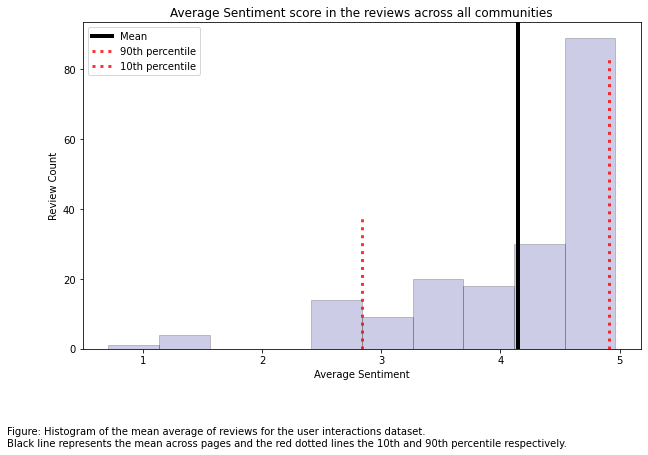

In [82]:
# Mean, 10th and 90th percentile of the sentiment

mean_rev= com0['score_scale2'].describe()['mean']

print(f'The mean of the sentiment in the reviews across all communities: {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(com0['score_scale2'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(com0['score_scale2'], 10))


# Add the percentiles to a list for the plotting
percentiles = [np.percentile(com0['score_scale2'], 90), np.percentile(com0['score_scale2'], 10)]


list_sentiment = list(zip(com0['recipe_id'], com0['score_scale2']))

plot_pretty_hist(list_sentiment,percentiles, mean_rev, plot_perct= True, 
                 title="Average Sentiment score in the reviews in community 0 ",
                 color = 'pink')

In [94]:
fig = px.bar(
    data_frame = com0,
    x = "recipe_id",
    y = ["rating","score_scale2"],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
    color_discrete_map={'rating':'green', 'score_scale2':'orange'},
    title='Average Rating vs Calculated Sentiment score (per recipe) in Community 0',
   # hover_name= 'recipe_id',
)

fig.update_layout(

  xaxis_title= 'Recipes in Community 0',
  yaxis_title = 'Score vs Rating',
  hovermode = 'x unified'

)

### c) **Average Rating vs Sentiment score per user by community**

In [107]:
# How many recipes have each user reviewed in each community???? 
df_count= pd.DataFrame(df_reviews2.groupby(by=["community",'user_id'])['recipe_id'].count())
df_count


recipe_id
community user_id              
0         57993               9
          63878               1
          310313              7
          315479             20
          325879              2
...                         ...
68        2002302691          1
69        1803099400          9
          2001597635          1
          2001640468          1
          2002274344          1

[15257 rows x 1 columns]

In [108]:
df_count = df_count.loc[1, :]
df_count = df_count.reset_index()
df_count['user_id'] = df_count['user_id'].astype(str)

fig = px.bar(
    data_frame = df_count,
    x = "user_id",
    y = ["recipe_id"],
    opacity = 0.9,
    orientation = "v",
    #barmode = 'group',
    #color_discrete_map={'rating':'green', 'score_scale2':'orange'},
    title='Nº of reviewd recipes per user in commnunity 0 ',
   # hover_name= 'recipe_id',
)

fig.update_layout(

  xaxis_title= 'Users in Community 0',
  yaxis_title = 'Recipe count',
  hovermode = 'x unified'

)


In [109]:
df_mean_rating_recipe_user= pd.DataFrame(df_reviews2.groupby(by=["community",'user_id'])['rating','score_scale2'].mean())
df_mean_rating_recipe_user

rating  score_scale2
community user_id                           
0         57993       4.777778      4.353629
          63878       5.000000      4.772681
          310313      4.857143      4.692218
          315479      4.650000      4.403541
          325879      5.000000      4.600677
...                        ...           ...
68        2002302691  5.000000      4.762831
69        1803099400  4.333333      4.666712
          2001597635  5.000000      4.268539
          2001640468  3.000000      2.476258
          2002274344  2.000000      2.476258

[15257 rows x 2 columns]

In [110]:
# Select community
com0_a = df_mean_rating_recipe_user.loc[0, :]
com0_a = com0_a.reset_index()
com0_a['user_id'] = com0_a['user_id'].astype(str)
com0_a

,user_id,rating,score_scale2
0,57993,4.777778,4.353629
1,63878,5.000000,4.772681
2,310313,4.857143,4.692218
3,315479,4.650000,4.403541
4,325879,5.000000,4.600677
...,...,...,...
217,2002286265,4.000000,4.593100
218,2002298217,5.000000,4.598404
219,2002308604,5.000000,3.635078
220,2002319310,0.000000,4.836583


In [ ]:
fig = px.bar(
    data_frame = com0_a,
    x = "user_id",
    y = ["rating","score_scale2"],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
    color_discrete_map={'rating':'green', 'score_scale2':'orange'},
    title='Average Rating vs Calculated Sentiment score (per user) in Community 0',
   # hover_name= 'recipe_id',
)

fig.update_layout(

  xaxis_title= 'Users in Community 0',
  yaxis_title = 'Score  vs Rating',
  hovermode = 'x unified'

)